In [1]:
!pip install pydicom
!pip install connected-components-3d

     |████████████████████████████████| 2.0 MB 5.2 MB/s 
     |████████████████████████████████| 2.6 MB 5.0 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = 'drive/MyDrive/deepMedic-CMU-4S-Pyramid-V1-post-Label/'

In [4]:
import pydicom as ds
import cv2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cc3d

In [17]:
import glob

# all dicom files
# there's only 102 mri pictures.
glob.glob(path+'*.dcm')

['drive/MyDrive/deepMedic-CMU-4S-Pyramid-V1-post-Label/3615498_result_18.dcm',
 'drive/MyDrive/deepMedic-CMU-4S-Pyramid-V1-post-Label/3615498_result_19.dcm',
 'drive/MyDrive/deepMedic-CMU-4S-Pyramid-V1-post-Label/3615498_result_83.dcm',
 'drive/MyDrive/deepMedic-CMU-4S-Pyramid-V1-post-Label/3615498_result_59.dcm',
 'drive/MyDrive/deepMedic-CMU-4S-Pyramid-V1-post-Label/3615498_result_55.dcm',
 'drive/MyDrive/deepMedic-CMU-4S-Pyramid-V1-post-Label/3615498_result_86.dcm',
 'drive/MyDrive/deepMedic-CMU-4S-Pyramid-V1-post-Label/3615498_result_61.dcm',
 'drive/MyDrive/deepMedic-CMU-4S-Pyramid-V1-post-Label/3615498_result_26.dcm',
 'drive/MyDrive/deepMedic-CMU-4S-Pyramid-V1-post-Label/3615498_result_87.dcm',
 'drive/MyDrive/deepMedic-CMU-4S-Pyramid-V1-post-Label/3615498_result_13.dcm',
 'drive/MyDrive/deepMedic-CMU-4S-Pyramid-V1-post-Label/3615498_result_3.dcm',
 'drive/MyDrive/deepMedic-CMU-4S-Pyramid-V1-post-Label/3615498_result_44.dcm',
 'drive/MyDrive/deepMedic-CMU-4S-Pyramid-V1-post-Labe

In [5]:
def create3DArray(type):
  # create zeros array to store all of pictures to be 3d array.
  abc = np.zeros((512,512,102))
  # store each picture into array
  for i in range(1,103):
    name = path+'3615498_result_'+str(i)+'.dcm'
    data = ds.dcmread(name)
    img = data.pixel_array
    abc[:,:,i-1] = img[:,:,type] # there're 3 type of brain hemorrhage store in these pics.
  return abc

In [6]:
abc_0 = create3DArray(0) # typeI hemorrhage
abc_1 = create3DArray(1) # typeII hemorrhage
abc_2 = create3DArray(2) # typeIII hemorrhage

In [7]:
# label all of components (26-connected by default)
labels_out = cc3d.connected_components(abc_0)

In [16]:
# find amount of components in this array
labels_out.max()

37

In [10]:
# compare size of each component
biggest, size = 0 ,0
for i in range(1,labels_out.max()+1):
  print('component%d:'%i,(labels_out==i).sum())
  if (labels_out==i).sum() > size:
    biggest = i
    size = (labels_out==i).sum()
print('\ncomponent%d'%biggest,'is the biggest one with %d voxels'%size)

component1: 669
component2: 5
component3: 72
component4: 151
component5: 5
component6: 1
component7: 7
component8: 42343
component9: 88
component10: 135
component11: 1
component12: 54
component13: 93
component14: 138
component15: 240
component16: 1
component17: 54
component18: 260
component19: 54
component20: 237
component21: 4
component22: 1451
component23: 350
component24: 94
component25: 662
component26: 1
component27: 1
component28: 39
component29: 2
component30: 4
component31: 3
component32: 31
component33: 21
component34: 16
component35: 7
component36: 1
component37: 12

component8 is the biggest one with 42343 voxels


In [8]:
def findminmax(x,num):
  # minimize volume for less time consuming of visualizing
  avai1st = []
  for i in range(x.shape[0]):
    if (x==num)[i,:,:].sum():
      avai1st.append(i)
  avai1st = np.array(avai1st)
  min1st = avai1st.min()
  max1st = avai1st.max()
  avai2nd = []
  for i in range(x.shape[1]):
    if (x==num)[:,i,:].sum():
      avai2nd.append(i)
  avai2nd = np.array(avai2nd)
  min2nd = avai2nd.min()
  max2nd = avai2nd.max()
  avai3rd = []
  for i in range(x.shape[2]):
    if (x==num)[:,:,i].sum():
      avai3rd.append(i)
  avai3rd = np.array(avai3rd)
  min3rd = avai3rd.min()
  max3rd = avai3rd.max()
  return min1st,max1st,min2nd,max2nd,min3rd,max3rd

In [15]:
from mpl_toolkits.mplot3d import Axes3D

def show_vol(num):
  x = labels_out.copy()
  min1st,max1st,min2nd,max2nd,min3rd,max3rd = findminmax(x,num)
  # visualize a specific component
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  ax.axis("off")
  ax.grid(True)
  ax.voxels((x==num)[min1st:max1st+1,min2nd:max2nd+1,min3rd:max3rd+1], facecolors='#7A88CC60', edgecolors='#7D84A6')
  plt.show()

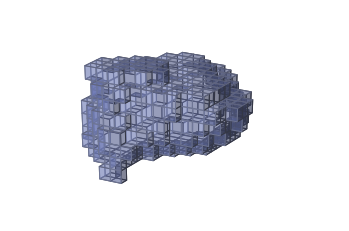

In [16]:
# visualize some of interesting components
show_vol(1)

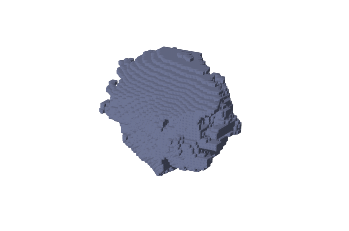

In [28]:
show_vol(8)

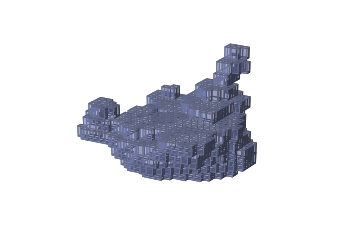

In [30]:
show_vol(22)

ABC/2 (original) method

In [46]:
# in traditional method, they'll estimating intracerebral haemorrhage volume as a ellipsoid with ABC/2 formula.
# find the biggest area to assume it as A*B
AB_area = 0
zall = []
for i in range(labels_out.shape[2]):
  voxels = (labels_out == biggest)[:,:,i]
  sum = voxels.sum()
  if sum:
    zall.append(i)
    dx,dy = np.where(voxels)
    zArray = np.array([dx*0.447265625,dy*0.447265625]).T # converse pixel to mm
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(zArray)
    area = pca.explained_variance_[0]*pca.explained_variance_[1] # A*B
    if area > AB_area: #find the biggest area
      AB_area = area
zall = np.array(zall)
zmin,zmax = zall.min(),zall.max() # for C calculation
# AB*C/2
AB_area*(zmax-zmin)*1.5/2/1000 # divide by 1000 to convert to cm

66.34994727685483

ABC/2 (improved) method

In [18]:
from sklearn.decomposition import PCA

# make 3D array with real proportion
dx,dy,dz = np.where(labels_out == biggest)
dfarray = np.array([dx*0.447265625,dy*0.447265625,dz*1.5]).T # converse pixel to mm
# use pca to find A,B,C values
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(dfarray)

# ABC/2 
pca.explained_variance_[0]*pca.explained_variance_[1]*pca.explained_variance_[2]/2/1000 # divide by 1000 to convert to cm^3

79.63334625073234

Disk method

In [63]:
# simpler and faster method
PixelCountArray = []
for i in range(labels_out.shape[2]):
  area = ((labels_out[:,:,i]==biggest)&(abc_0[:,:,i]==255)).sum()*0.447265625*0.447265625 # turn pixel to area(distance between pixel is 0.447265625mm)
  PixelCountArray.append(area)
PixelCountArray = np.array(PixelCountArray)
diskmethod = PixelCountArray.sum()*1.5/1000 # distance between each mri 1.5mm
diskmethod

12.705855920791626

Truncated method

In [73]:
def sumtrun(array):
  sumtruncated = 0
  for i in range(array.shape[0]-1):
    A1 = array[i]
    A2 = array[i+1]
    sumtruncated += 1/3*(A1+A2+np.sqrt(A1*A2))
  sumtruncated *= 1.5/1000
  return sumtruncated

In [75]:
truncatedmethod = sumtrun(PixelCountArray)
truncatedmethod

12.676752025108097